### Содержание

1. [Получение контекста последовательности с помощью pyfaidx](#Получение-контекста-последовательности-с-помощью-pyfaidx)
2. [Автоматизируем получение контекста (прямо из таблицы с данными)](#Автоматизируем-получение-контекста-(прямо-из-таблицы-с-данными))  
   2.1 [Подготовка датафрейма](Подготовка-датафрейма)  
   2.2 [Получение контекста](Получение-контекста)
4. [Получение sequence logo с помощью _logomaker_](#Получение-sequence-logo-с-помощью-logomaker)
5. [Получение sequence logo с помощью _seqlogo_](#Получение-sequence-logo-с-помощью-seqlogo)
6. [Пересечение интервалов интересующих позиций](#Пересечение-интервалов-интересующих-позиций)

### Получение контекста последовательности с помощью pyfaidx

In [205]:
# TODO
# Обработать дупликаты (когда в одной позиции n замен)

In [1]:
from pyfaidx import Fasta

https://pypi.org/project/pyfaidx/

Загружаем нашу фасту с транскриптами, на этом этапе создается индекс fai.  

Дополнительно кастомизируем ключи, т.к. в файле траснкриптов ключи выглядят так:  
`ENST00000353265.8|ENSG00000178184.16|OTTHUMG00000132922.4|OTTHUMT00000256435.3|PARD6G-201|PARD6G|3836|protein_coding|`  
А нам нужна только их первая часть.

In [2]:
transcript_fasta = Fasta('data_dir/gencode.v45.transcripts.fa.gz', key_function = lambda x: x.split('.')[0])

Интересующий транскрипт и позиция:

In [134]:
transcript_id = 'ENST00000353265'
position_of_interest = 34

In [135]:
len(transcript_fasta[transcript_id])

3836

Индексация с 0, поэтому чтобы получить позицию 34, вводим 33:

In [142]:
transcript_fasta[transcript_id][33]

>ENST00000353265:34-34
C

Утилита работает как словарь, тогда по примеру из документации:

In [143]:
transcript_fasta[transcript_id][position_of_interest - 5 : position_of_interest + 5].complement

>ENST00000353265:30-39 (complement)
CGTCGTGGCC

Обратите внимание, это **комплементарная** последовательность!

In [124]:
sequence = 'CGTCGTGGCC'

In [125]:
for i, nucleotide in enumerate(sequence, 30):
    print(f"{i} - {nucleotide}")

30 - C
31 - G
32 - T
33 - C
34 - G
35 - T
36 - G
37 - G
38 - C
39 - C


Проверила глазами по таблице, всё сходится.

### Автоматизируем получение контекста (прямо из таблицы с данными)

Вот так можно автоматизировать вытягивание контекста, работая напрямую с таблицей tsv:

#### Подготовка датафрейма

In [21]:
import pandas as pd

from os.path import join

In [51]:
DATA_PATH = "data_dir"

Преобразуем имеющиеся таблицы в датафреймы.

In [52]:
chr18 = pd.read_table(join(DATA_PATH, "uniqs_18chr.tsv"))
chr21 = pd.read_table(join(DATA_PATH, "uniqs_21chr.tsv"))
chr22 = pd.read_table(join(DATA_PATH, "uniqs_22chr.tsv"))

In [182]:
print(chr18.shape)
print(chr21.shape)
print(chr22.shape)

(1104782, 8)
(739635, 8)
(1621638, 8)


Объединяем всё в один датафрейм.

In [191]:
frames = [chr18, chr21, chr22]
final_df = pd.concat(frames)

In [192]:
final_df.shape

(3466055, 8)

In [193]:
final_df.head()

,Chr,Position,rsID,Ref,Alt,Consequence,Canonical_transcript,cDNA_position
0,chr18,46050,rs744323,C,T,downstream_gene_variant,ENST00000308911,NaN
1,chr18,47239,.,TTTA,T,3_prime_UTR_variant,ENST00000308911,1541-1543
2,chr18,47242,rs893233952,A,G,3_prime_UTR_variant,ENST00000308911,1541
3,chr18,47243,.,T,C,3_prime_UTR_variant,ENST00000308911,1540
4,chr18,47245,rs1486723371,A,G,3_prime_UTR_variant,ENST00000308911,1538


In [194]:
final_df.dtypes

Chr                     object
Position                 int64
rsID                    object
Ref                     object
Alt                     object
Consequence             object
Canonical_transcript    object
cDNA_position           object
dtype: object

In [195]:
filtered_df = final_df[~final_df['Consequence'].astype(str).str.contains(',')]
lof_final_df = filtered_df[filtered_df['Consequence'].str.contains('stop_gained', na=False)]
lof_final_df

,Chr,Position,rsID,Ref,Alt,Consequence,Canonical_transcript,cDNA_position
82,chr18,47411,.,A,C,stop_gained,ENST00000308911,1372
84,chr18,47411,rs774102370,A,T,stop_gained,ENST00000308911,1372
94,chr18,47425,rs1348242192,C,A,stop_gained,ENST00000308911,1358
104,chr18,47449,rs758861544,G,A,stop_gained,ENST00000308911,1334
105,chr18,47450,rs780641694,A,C,stop_gained,ENST00000308911,1333
...,...,...,...,...,...,...,...,...
1619819,chr22,50769106,rs559977293,G,A,stop_gained,ENST00000691320,715
1620148,chr22,50769969,.,C,T,stop_gained,ENST00000691320,534
1620665,chr22,50775796,rs1555923164,G,T,stop_gained,ENST00000691320,462
1620705,chr22,50775845,.,C,T,stop_gained,ENST00000691320,413


In [207]:
lof_final_df['Position'].nunique()

14757

#### Получение контекста

В таблице есть пустые поля в столбце `cDNA_position`, при итерации они отмечаются как `nan` (т.е. `<class 'float'>`). Если значение не пустое, оно имеет тип `str`, так что для работы `pyfaidx` приходится приводить его к `int`.

**Пропускаем позиции, которые слишком близко (`<=5`) к началу или концу транскрипта.**

Записываем контекст в отдельную колонку датафрейма.

In [113]:
transcript_fasta = Fasta(join(DATA_PATH, 'gencode.v45.transcripts.fa.gz'), key_function=lambda x: x.split('.')[0])

In [203]:
sequences = []

for index, row in lof_final_df.iterrows():
    transcript_id = row['Canonical_transcript']
    position_of_interest = row['cDNA_position']

    if isinstance(position_of_interest, str) and '-' not in position_of_interest:
        position_of_interest = int(position_of_interest)

        # Транскрипта может не быть в базе
        if transcript_id in transcript_fasta:
            transcript_length = len(transcript_fasta[transcript_id])

            # Не рассматриваем крайние случаи
            if 5 < position_of_interest < transcript_length - 5:
                sequence_of_interest = str(transcript_fasta[transcript_id][position_of_interest - 5: position_of_interest + 5])
            else:
                sequence_of_interest = None
        else:
            sequence_of_interest = None
    else:
        sequence_of_interest = None
    
    sequences.append(sequence_of_interest)


lof_final_df.loc[:, 'Context'] = sequences

In [204]:
lof_final_df.head()

,Chr,Position,rsID,Ref,Alt,Consequence,Canonical_transcript,cDNA_position,Context
82,chr18,47411,.,A,C,stop_gained,ENST00000308911,1372,AGTATGCCGA
84,chr18,47411,rs774102370,A,T,stop_gained,ENST00000308911,1372,AGTATGCCGA
94,chr18,47425,rs1348242192,C,A,stop_gained,ENST00000308911,1358,GGAGGAGGAT
104,chr18,47449,rs758861544,G,A,stop_gained,ENST00000308911,1334,ATATCAGGAT
105,chr18,47450,rs780641694,A,C,stop_gained,ENST00000308911,1333,AATATCAGGA


### Получение sequence logo с помощью _logomaker_

In [83]:
import logomaker as lm

https://github.com/jbkinney/logomaker/blob/master/logomaker/tutorials

Сам всё делает, надо только подать список последовательностей.

Переносим все значения в список, удаляем пустые значения.

In [199]:
context = lof_final_df['Context'].tolist()
print(len(context))

14978


In [129]:
print(context[:20])

['AGTATGCCGA', 'AGTATGCCGA', 'GGAGGAGGAT', 'ATATCAGGAT', 'AATATCAGGA', 'TCAGCAATAT', 'CATTCAAGAT', 'CCTGTGACCC', 'CCAGCAGTAC', 'CAGCCAGCAG', 'AGGCCAGCTG', 'CATGCCTGCG', None, 'TATATGACAT', 'AGTACCCAGA', 'TTTCCAGCTG', 'CACAGAAGGC', 'CGGGCAGGTC', 'CACTCGGGGC', 'GGTACGTGCC']


In [222]:
filtered_context = [x for x in context if x is not None]
print(len(filtered_context))

14435


In [224]:
counts_mat = lm.alignment_to_matrix(filtered_context)
counts_mat

,A,C,G,T
pos,,,,
0,3315,3998,3997,3125
1,3564,4126,4024,2721
2,3329,2775,2326,6005
3,3439,2708,4149,4139
4,744,8382,4293,1016
5,8375,830,4687,543
6,6064,1068,6162,1141
7,3655,3683,4590,2507
8,4454,3234,3303,3444


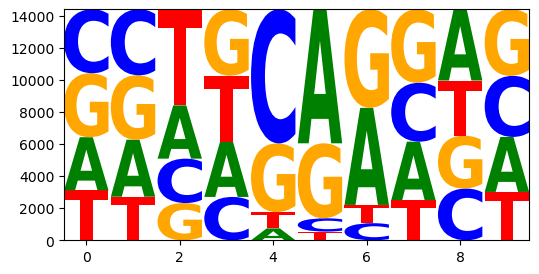

In [215]:
lm.Logo(counts_mat, figsize=(6, 3))

In [201]:
prob_mat = lm.transform_matrix(counts_mat, from_type='counts', to_type='probability')

/home/tesselle/miniforge3/envs/bi_project/lib/python3.11/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.22965579 0.24690075 0.23062539 0.23824365 0.05159637 0.58009557
 0.42004294 0.25320313 0.30853937 0.23810513]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/home/tesselle/miniforge3/envs/bi_project/lib/python3.11/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.27695824 0.28582312 0.19225708 0.18761687 0.58058037 0.05755246
 0.0740356  0.25514232 0.22404599 0.26442274]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/home/tesselle/miniforge3/envs/bi_projec

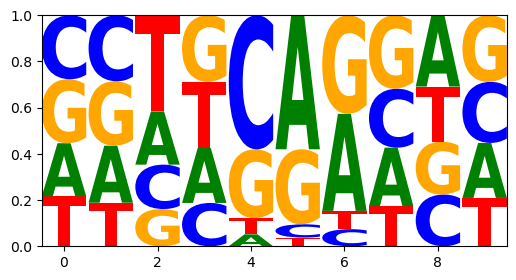

In [179]:
lm.Logo(prob_mat, figsize=(6, 3))

### Получение sequence logo с помощью _seqlogo_

In [132]:
import numpy as np
import seqlogo

https://pypi.org/project/seqlogo/

Работает с позиционными матрицами:  

**Position Frequency Matrix (PFM)**:  
В ячейках PFM содержатся частоты каждого нуклеотида на соответствующей позиции в наборе последовательностей.
PFM не нормализуется по вероятностям, поэтому сумма значений в каждой строке может быть больше 1.  
  
**Position Probability Matrix (PPM)**:  
В отличие от PFM, значения в PPM нормализуются по вероятностям, так что сумма значений в каждой строке равна 1.
PPM показывает вероятность появления каждого нуклеотида на каждой позиции в последовательности.  

**Position Weight Matrix (PWM)**:  
Значения в PWM выражены в виде весов, которые показывают предпочтительность каждого нуклеотида на каждой позиции. Веса обычно вычисляются как логарифм отношения частоты наблюдения нуклеотида к ожидаемой частоте нуклеотида на данной позиции.

Для начала надо из списка контекстов создать Position Probability Matrix.

In [226]:
# Преобразование списка контекстов в массив нампай
sequences_array = np.array(filtered_context)

# Можно удалить наны на этом шаге
# sequences_array = sequences_array[sequences_array != None]

# Создание пустого массива для хранения частот
freq_array = np.zeros((len(sequences_array[0]), 4))

# Вычисление частоты каждой буквы на каждой позиции
for i, seq in enumerate(sequences_array):
    for j, nt in enumerate(seq):
        if nt == 'A':
            freq_array[j][0] += 1
        elif nt == 'C':
            freq_array[j][1] += 1
        elif nt == 'G':
            freq_array[j][2] += 1
        elif nt == 'T':
            freq_array[j][3] += 1

# Нормализация частоты
freq_array /= len(sequences_array)
freq_array

array([[0.22965016, 0.27696571, 0.27689643, 0.2164877 ],
       [0.2468999 , 0.28583304, 0.27876689, 0.18850017],
       [0.23062002, 0.19224108, 0.16113613, 0.41600277],
       [0.23824039, 0.18759958, 0.28742639, 0.28673363],
       [0.05154139, 0.58067198, 0.29740215, 0.07038448],
       [0.58018705, 0.05749913, 0.32469692, 0.0376169 ],
       [0.42009006, 0.07398684, 0.42687911, 0.07904399],
       [0.25320402, 0.25514375, 0.31797714, 0.1736751 ],
       [0.30855559, 0.22403879, 0.22881884, 0.23858677],
       [0.23810184, 0.26442674, 0.28818843, 0.20928299]])

In [218]:
ppm = seqlogo.Ppm(freq_array)
ppm

,A,C,G,T
0,0.229650,0.276966,0.276896,0.216488
1,0.246900,0.285833,0.278767,0.188500
2,0.230620,0.192241,0.161136,0.416003
3,0.238240,0.187600,0.287426,0.286734
4,0.051541,0.580672,0.297402,0.070384
5,0.580187,0.057499,0.324697,0.037617
6,0.420090,0.073987,0.426879,0.079044
7,0.253204,0.255144,0.317977,0.173675
8,0.308556,0.224039,0.228819,0.238587
9,0.238102,0.264427,0.288188,0.209283


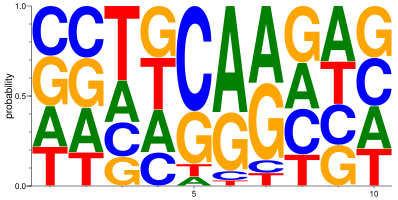

In [219]:
seqlogo.seqlogo(ppm, ic_scale = False, format = 'svg', size = 'medium')

**<font color='brown'> Числа для построения лого в обеих библиотеках совпадают, но графики незначительно отличаются.**

### Пересечение интервалов интересующих позиций

In [3]:
import pandas as pd
from os.path import join

In [29]:
DATA_PATH = "data_dir"
data = pd.read_table(join(DATA_PATH, "deduplicated.tsv"))
data.head()

,Chr,Position,rsID,Ref,Alt,Consequence,Canonical,Gene_symbol,Domains,LoF,LoF_flag,LoF_filter
0,chr18,46050,rs744323,C,T,"['ENST00000308911: downstream_gene_variant', '...","ENST00000308911: YES, ENST00000572530: YES, EN...","TUBB8B, LOC105371950",NaN,NaN,NaN,NaN
1,chr18,47239,.,TTTA,T,"['ENST00000308911: 3_prime_UTR_variant', 'ENST...","ENST00000308911: YES, ENST00000572530: YES, EN...","TUBB8B, LOC105371950",NaN,NaN,NaN,NaN
2,chr18,47242,rs893233952,A,G,"['ENST00000308911: 3_prime_UTR_variant', 'ENST...","ENST00000308911: YES, ENST00000572530: YES, EN...","TUBB8B, LOC105371950",NaN,NaN,NaN,NaN
3,chr18,47243,.,T,C,"['ENST00000308911: 3_prime_UTR_variant', 'ENST...","ENST00000308911: YES, ENST00000572530: YES, EN...","TUBB8B, LOC105371950",NaN,NaN,NaN,NaN
4,chr18,47245,.,A,T,"['ENST00000308911: 3_prime_UTR_variant', 'ENST...","ENST00000308911: YES, ENST00000572530: YES, EN...","TUBB8B, LOC105371950",NaN,NaN,NaN,NaN


In [7]:
data.shape

(339, 12)

Из распарсенной таблицы отобрали только строки, содержащие непустые значения в одном из лоф-полей (LoF/LoF_flag/LoF_filter)  

In [30]:
filtered_data = data[(~data['LoF'].isna()) | (~data['LoF_flag'].isna()) | (~data['LoF_filter'].isna())]

In [21]:
filtered_data.shape

(10, 12)

Перевели в vcf

In [32]:
vcf_df = filtered_data[['Chr', 'Position', 'rsID', 'Ref', 'Alt']] 
vcf_df.loc[:, 'QUAL'] = "."
vcf_df.loc[:, 'FILTER'] = "."
vcf_df.loc[:, 'INFO'] = "."

header = """##fileformat=VCFv4.2
#CHROM POS ID REF ALT QUAL FILTER INFO
"""

output_VCF = "data_dir/myfile.vcf"
with open(output_VCF, 'w') as vcf:
    vcf.write(header)

vcf_df.to_csv(output_VCF, sep="\t", mode='a', index=False, header=False)

/tmp/ipykernel_4995/4217350662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vcf_df.loc[:, 'QUAL'] = "."
/tmp/ipykernel_4995/4217350662.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vcf_df.loc[:, 'FILTER'] = "."
/tmp/ipykernel_4995/4217350662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Сделала  
! bedtools intersect -wo -a myfile.vcf -b gencode.v45.annotation.gtf.gz > intersected_annotations.gtf

Получился файл intersected_annotations.gtf